# Plant Seedlings Classification

https://www.kaggle.com/competitions/plant-seedlings-classification

## Setup

In [1]:
import os
import glob
from pathlib import Path
import random
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torchinfo

In [2]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

COMP_NAME = 'plant-seedlings-classification'
if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

DATA_PATH = Path('../input/' + COMP_NAME) if IS_KAGGLE else Path('./data')

RANDOM_SEED = 42
BATCH_SIZE = 32

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle:', 'Y' if IS_KAGGLE else 'N')
print('torch version:', torch.__version__)
print('device:', DEVICE)
print(torch.cuda.device_count(), 'GPU(s) available')

kaggle: Y
torch version: 2.0.0+cpu
device: cpu
0 GPU(s) available


In [4]:
# reproducibility

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load Data

In [5]:
path = Path('./data')
if not DATA_PATH.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(COMP_NAME)
    zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(DATA_PATH)

In [6]:
# values from ImageNet, recommended by PyTorch
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std),
])

all_ds = datasets.ImageFolder(root=DATA_PATH/'train', transform=transform)

NOTE:
+ `ImageFolder` is good for apply transform for the whole image folder (return torch dataset) 

## Data Exploration

In [7]:
all_samples = len(all_ds)

print(all_samples, 'samples')
print(len(all_ds.classes), 'labels')

4750 samples
12 labels


In [8]:
label_counts = []

for d in glob.glob(os.path.join(DATA_PATH/'train', '*')):
    label = os.path.basename(d)
    count = len(glob.glob(os.path.join(d, '*')))
    label_counts.append({'label': label, 'count': count})

label_counts_df = pd.DataFrame(label_counts)
print(label_counts_df)

                        label  count
0           Scentless Mayweed    516
1                Common wheat    221
2                    Charlock    390
3                 Black-grass    263
4                  Sugar beet    385
5            Loose Silky-bent    654
6                       Maize    221
7                    Cleavers    287
8            Common Chickweed    611
9                     Fat Hen    475
10  Small-flowered Cranesbill    496
11            Shepherds Purse    231


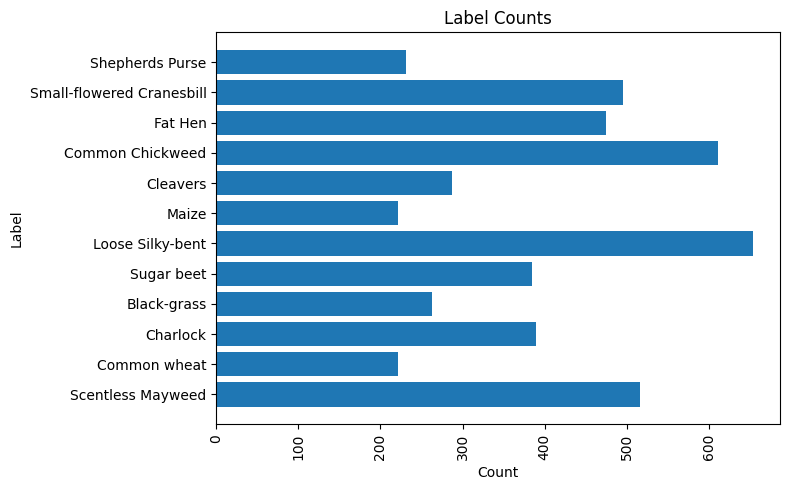

In [9]:
plt.figure(figsize=(8, 5))
plt.barh(label_counts_df['label'], label_counts_df['count'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Counts')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

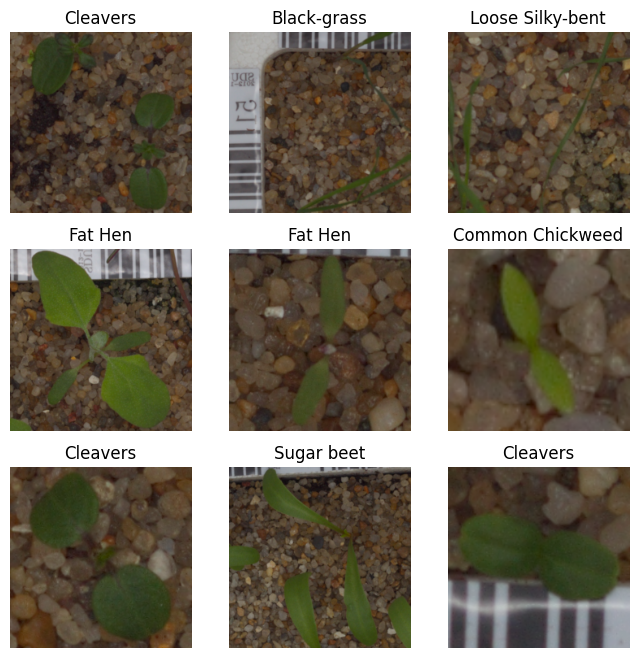

In [10]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

labels = all_ds.classes

for i in range(1, cols * rows + 1):
    sample = all_ds[random.randint(0, len(all_ds)-1)]
    label = sample[1]
    
    img = sample[0].permute(1, 2, 0) # (3, 224, 224) -> (224, 224, 3)
    img = transform_std * np.array(img) + transform_mean # undo normalization
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Prepare Training/Validation Data

In [11]:
train_ds, valid_ds = torch.utils.data.random_split(all_ds, [3750, 1000])

print('train:', len(train_ds), 'samples')
print('valid:', len(valid_ds), 'samples')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train: 3750 samples
valid: 1000 samples


NOTE:
+ We can still split the dataset into train and val using `random_split`

## Build Model

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [ ]:
model

In [ ]:
input_features = model.fc.in_features
model.fc = nn.Linear(input_features, len(all_ds.classes), device=DEVICE)
model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.25)

print(model)
torchinfo.summary(model, (BATCH_SIZE, 3, 224, 224), col_names=('input_size', 'output_size', 'num_params', 'kernel_size'), verbose=0)

NOTE:
+ using `torchinfo.summary` can help you get get a deep look into your model

## Train Model

In [ ]:
def train_step(dataloader, model, loss_fn, optimizer, print_every=100):
    losses = []
    model.train()

    for batch, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        # print results
        if batch % print_every == 0:
            loss, current = loss.item(), (batch + 1) * len(inputs)
            print(f'  Training: Loss = {loss:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]')
    return losses

In [ ]:
def valid_step(dataloader, model, loss_fn):
    model.eval()
    loss, correct = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss += loss_fn(outputs, targets).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets.data).sum().item()

    loss /= BATCH_SIZE
    correct /= len(dataloader.dataset)
    print(f'  Validation: Accuracy={(100 * correct):>0.1f}%, Average_Loss={loss:>8f}\n')

In [ ]:
epochs = 10
losses = []

for epoch in range(epochs):
    print(f'Epoch [{epoch+1:>2d}/{epochs}]\n-------------------------------')
    epoch_losses = train_step(train_loader, model, loss_fn, optimizer, print_every=25)
    valid_step(valid_loader, model, loss_fn)
    losses.extend(epoch_losses)

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(losses)
plt.title('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

## Submission

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_path, transform=None):
        self.test_path = test_path
        self.transform = transform

    def __len__(self):
        return len(glob.glob(f'{self.test_path}/*.png'))

    def __getitem__(self, index):
        img_path = os.path.join(self.test_path, os.listdir(self.test_path)[index])
        img = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img)
        return img

In [ ]:
test_path = DATA_PATH/'test'

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(transform_mean, transform_std)
])

test_ds = TestDataset(test_path, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print('Test:', len(test_ds), 'samples')

In [ ]:
labels = []

model.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        labels.extend(preds.cpu().numpy().tolist())

species = [all_ds.classes[label] for label in labels]

submission = pd.DataFrame({'file': os.listdir(test_path), 'species': species})
submission.to_csv('submission.csv', index=False)

In [ ]:
%cd /kaggle

In [ ]:
!ls working